In [76]:
# pip install py2neo

In [77]:
import numpy as np 
import pandas as pd
from py2neo import Graph
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import time

In [78]:
# df = pd.read_csv('./DataSet/IMDB_Top250Engmovies2_OMDB_Detailed.csv')
df = pd.read_csv('./DataSet/Top1000_Movies.csv')
df["Year"] = pd.to_datetime(df['Year'])

df.head()

,index,Movie Name,Year,Actors,Directors,Writer,Rating
0,0,Adams Apples,2005-04-15,"Ulrich Thomsen, Mads Mikkelsen, Nicolas Bro",Anders Thomas Jensen,Anders Thomas Jensen,7.7
1,1,Knockin on Heavens Door,1997-02-20,"Til Schweiger, Jan Josef Liefers, Thierry van ...",Thomas Jahn,"Thomas Jahn, Til Schweiger",7.9
2,2,Mr. Nobody,2013-09-26,"Jared Leto, Sarah Polley, Diane Kruger",Jaco Van Dormael,Jaco Van Dormael,7.8
3,3,Nostalghia,1992-01-03,"Oleg Yankovskiy, Erland Josephson, Domiziana G...",Andrei Tarkovsky,"Andrei Tarkovsky, Tonino Guerra",8
4,4,The Man from Nowhere,2010-05-08,"Won Bin, Kim Sae-ron, Kim Tae-hoon",Jeong-beom Lee,Jeong-beom Lee,7.7


In [79]:
df['Year']=df['Year'].dt.strftime('%Y')

In [80]:
df.tail()

,index,Movie Name,Year,Actors,Directors,Writer,Rating
994,994,Tumbbad,2018,"Sohum Shah, Jyoti Malshe, Anita Date","Rahi Anil Barve, Anand Gandhi, Adesh Prasad","Mitesh Shah, Adesh Prasad, Rahi Anil Barve",8.3
995,995,The Gentlemen,2020,"Matthew McConaughey, Charlie Hunnam, Michelle ...",Guy Ritchie,"Guy Ritchie, Ivan Atkinson, Marn Davies",7.8
996,996,Hamilton,2020,"Lin-Manuel Miranda, Phillipa Soo, Leslie Odom Jr.",Thomas Kail,"Lin-Manuel Miranda, Ron Chernow",8.4
997,997,Dark Waters,2019,"Mark Ruffalo, Anne Hathaway, Tim Robbins",Todd Haynes,"Nathaniel Rich, Mario Correa, Matthew Michael ...",7.6
998,998,Asuran,2019,"Dhanush, Manju Warrier, Prakash Raj",Vetrimaaran,"M.S. Manimaran, Vetrimaaran, Suka",8.6


In [81]:
sandbox = False

if sandbox:
    ip="34.205.9.217"
    port="7474"
    pwd="composition-sunlight-mediums"
    graph = Graph("bolt://34.205.9.217:7687", auth=("neo4j", pwd))
else :
    graph = Graph("bolt://localhost:11005", auth=("neo4j", "root"))

In [82]:
LOAD_DATA = True

def run_request(request,LOAD_DATA):
    if (LOAD_DATA):
        start_time = time.time()
        print(graph.run(request)) 
        exec_time = time.time() - start_time
        print(f'-- {exec_time} seconds --')

In [83]:
request_delete ="""
MATCH (n) DETACH DELETE n;
"""
run_request(request_delete,LOAD_DATA)

(No data)
-- 0.28655052185058594 seconds --


In [84]:
list(df.columns)
# len(df.columns)

['index', 'Movie Name', 'Year', 'Actors', 'Directors', 'Writer', 'Rating']

In [85]:
request ="""
CREATE (m:Movie {id:$index,name: $Movie_Name})
SET 
m.directors = $director,
m.Year = $year, 
m.rating = $rating,
m.cast=$cast,
m.writers = $writer
"""
start_time = time.time()
count=df.shape[0]
if (LOAD_DATA):
  for index, row in df.iterrows():
    graph.run(request,
              index=row['index'],
              Movie_Name=row['Movie Name'],
              director=None if pd.isnull(row['Directors']) else row['Directors'],
              year= None if pd.isnull(row['Year']) else row['Year'],
              rating=None if pd.isnull(row['Rating']) else row['Rating'],          
              cast= None if pd.isnull(row['Actors']) else row['Actors'],
              writer=None if pd.isnull(row['Writer']) else row['Writer']
              )
    if (index%100==0):
        exec_time = time.time()- start_time
        print(f'{index}/{df.shape[0]} done ... -- {exec_time} seconds --')
    
  exec_time = time.time()- start_time
  print(f' ... End ... -- {exec_time} seconds --') 

0/999 done ... -- 0.009245157241821289 seconds --
100/999 done ... -- 0.586158037185669 seconds --
200/999 done ... -- 1.1177985668182373 seconds --
300/999 done ... -- 1.6667449474334717 seconds --
400/999 done ... -- 2.1884877681732178 seconds --
500/999 done ... -- 2.7620091438293457 seconds --
600/999 done ... -- 3.2937381267547607 seconds --
700/999 done ... -- 3.8387866020202637 seconds --
800/999 done ... -- 4.413896083831787 seconds --
900/999 done ... -- 4.960493326187134 seconds --
 ... End ... -- 5.479809284210205 seconds --


In [86]:
request ="""
MATCH (m:Movie)
WHERE m.cast IS NOT NULL
WITH m
UNWIND split(m.cast, ',') AS actor
MERGE (p:Person {name: trim(actor)})
MERGE (p)-[r:ACTED_IN]->(m);
"""    
run_request(request,LOAD_DATA)

(No data)
-- 1.0273470878601074 seconds --


In [87]:
request =""" 
MATCH (m:Movie)
WHERE m.directors IS NOT NULL
WITH m
MERGE (d:Person {name: m.directors})
MERGE (d)-[r:DIRECTED]->(m);
"""
run_request(request,LOAD_DATA) 

(No data)
-- 0.9247043132781982 seconds --


In [88]:
request = """
MATCH (p:Person)-[rel:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(p2:Person)
MERGE (p)-[r:WORK_WITH]-(p2);
"""
run_request(request,LOAD_DATA) 

(No data)
-- 2.7560949325561523 seconds --


##Useful

In [89]:
nodes_df['label']

0     Movie
1    Person
Name: label, dtype: object

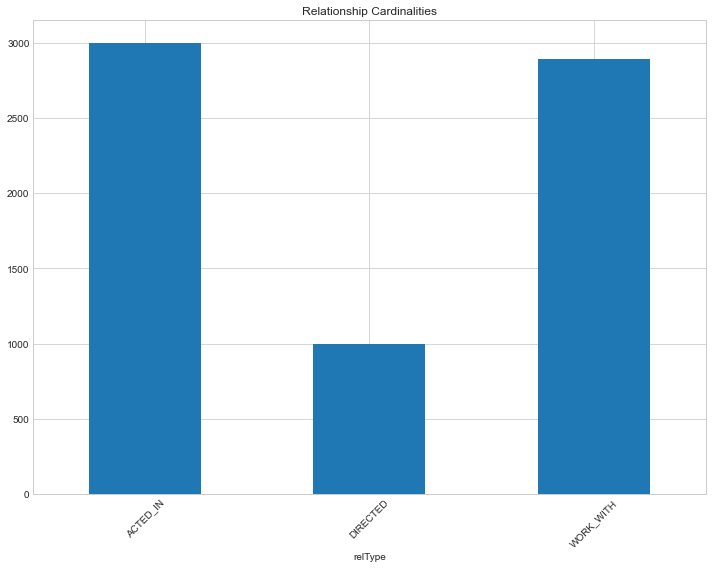

In [90]:
result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities",figsize=(10,8))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [91]:
request_top_5_actor="""
MATCH (p:Person)-[rel:ACTED_IN]->(m:Movie)
WITH p,collect(m.name) as movies,count(*) as total
RETURN  p.name as Actor, movies As Movies_Acted_In,total As Total_Movies
ORDER BY total DESC
LIMIT 5
"""
graph.run(request_top_5_actor).to_data_frame().head()

,Actor,Movies_Acted_In,Total_Movies
0,Robert De Niro,"[Silver Linings Playbook, Joker, Cape Fear, Th...",17
1,Al Pacino,"[The Godfather, Scarface, The Irishman, Glenga...",14
2,Tom Hanks,"[Road to Perdition, Captain Phillips, The Gree...",14
3,Christian Bale,"[The Fighter, Ford v Ferrari, Batman Begins, T...",11
4,Leonardo DiCaprio,"[The Wolf of Wall Street, Shutter Island, The ...",11


In [92]:
def who_be_present(I_AM,I_WANT_TO_MEET):
    print(f"I'm {I_AM}")
    print(f"I want to meet {I_WANT_TO_MEET}")
    request="""
    MATCH (cs:Person { name: $pfrom }),(ms:Person { name: $pto }), p = shortestPath((cs)-[:ACTED_IN|DIRECTED*]-(ms))
    WHERE length(p)> 1 
    RETURN p
    """
    cursor = graph.run(request,pfrom=I_AM,pto=I_WANT_TO_MEET)
    while cursor.forward():
        print(cursor['p'])
    print('\n')
        
        
I_AM='Brad Anderson'
I_WANT_TO_MEET='Brad Pitt'
who_be_present(I_AM,I_WANT_TO_MEET)

I_AM='Charles Chaplin'
I_WANT_TO_MEET='Virginia Cherrill'
who_be_present(I_AM,I_WANT_TO_MEET)

I'm Brad Anderson
I want to meet Brad Pitt
(Brad Anderson)-[:DIRECTED {}]->(The Machinist)<-[:ACTED_IN {}]-(Jennifer Jason Leigh)-[:ACTED_IN {}]->(The Hateful Eight)<-[:DIRECTED {}]-(Quentin Tarantino)-[:DIRECTED {}]->(Once Upon a Time... In Hollywood)<-[:ACTED_IN {}]-(Brad Pitt)


I'm Charles Chaplin
I want to meet Virginia Cherrill
(Charles Chaplin)-[:DIRECTED {}]->(City Lights)<-[:ACTED_IN {}]-(Virginia Cherrill)




In [97]:
request_link_prediction_movie="""
MATCH (a:Movie {name:$ptitle} )-[*4]-(b:Movie)
WHERE a <> b AND a.name < b.name
WITH DISTINCT a,b
RETURN a.name as title, b.name as recommendation, gds.alpha.linkprediction.adamicAdar(a, b) AS score
ORDER BY score DESC
LIMIT 10
"""
print(graph.run(request_link_prediction_movie,ptitle="Mirror").to_data_frame())
print(graph.run(request_link_prediction_movie,ptitle="Once Upon a Time in America").to_data_frame())

    title recommendation     score
0  Mirror     Nostalghia  0.558111
1  Mirror        Stalker  0.558111
2  Mirror  The Sacrifice  0.558111
                         title                  recommendation     score
0  Once Upon a Time in America  The Good, the Bad and the Ugly  0.621335
1  Once Upon a Time in America                     Taxi Driver  0.259730
2  Once Upon a Time in America                The Untouchables  0.259730
3  Once Upon a Time in America          The Godfather: Part II  0.259730
4  Once Upon a Time in America                 The Deer Hunter  0.259730
5  Once Upon a Time in America                    The Irishman  0.259730
6  Once Upon a Time in America                     Raging Bull  0.259730
7  Once Upon a Time in America              The King of Comedy  0.259730
8  Once Upon a Time in America         Silver Linings Playbook  0.259730
9  Once Upon a Time in America                     The Leopard  0.000000
